In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# code adapted from ChatGPT

# Define your neural network model
class SL2Z_NN(nn.Module):
    def __init__(self):
        super(SL2Z_NN, self).__init__()

        self.step1 = nn.Linear(4, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SL2Z_NN()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        scheduler.step()
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [3]:
df = pd.read_csv("../Data_Generation/Data_files/subset3_train_rows_SL2Z_Q_learn.csv")
test_df = pd.read_csv("../Data_Generation/Data_files/subset3_test_rows_SL2Z_Q_learn.csv")


train = df.drop("num_moves_Q_learning_needs", axis=1)
# random.seed(42)
# np.random.seed(42)
# reordered = df.sample(frac=1).reset_index(drop=True)
# bound = int(reordered.shape[0] * 0.6)
# plus_one = bound+1

# train = reordered.iloc[1:bound]
# test_df = reordered.iloc[plus_one:reordered.shape[0]]

In [4]:
just_input = train.drop('first_move_by_Q_learning', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

In [5]:
desired_output = torch.tensor(train['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long()

/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_10569/3137828461.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 2.8069804906845093
Epoch [1/500], Loss: 1.4035
total loss: 2.6596325635910034
Epoch [2/500], Loss: 1.3298
total loss: 2.5911247730255127
Epoch [3/500], Loss: 1.2956
total loss: 2.545790910720825
Epoch [4/500], Loss: 1.2729
total loss: 2.5209057331085205
Epoch [5/500], Loss: 1.2605
total loss: 2.498479127883911
Epoch [6/500], Loss: 1.2492
total loss: 2.4074506759643555
Epoch [7/500], Loss: 1.2037
total loss: 2.356298089027405
Epoch [8/500], Loss: 1.1781
total loss: 2.3306808471679688
Epoch [9/500], Loss: 1.1653
total loss: 2.3237205743789673
Epoch [10/500], Loss: 1.1619
total loss: 2.3179855346679688
Epoch [11/500], Loss: 1.1590
total loss: 2.31781804561615
Epoch [12/500], Loss: 1.1589
total loss: 2.3177011013031006
Epoch [13/500], Loss: 1.1589
total loss: 2.280306816101074
Epoch [14/500], Loss: 1.1402
total loss: 2.280889391899109
Epoch [15/500], Loss: 1.1404
total loss: 2.267929434776306
Epoch [16/500], Loss: 1.1340
total loss: 2.256562829017639
Epoch [17/500], Loss: 1.128

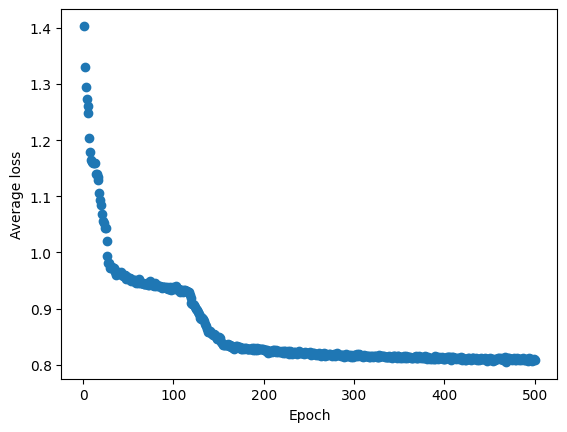

In [6]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.0005, viz_accuracy=True)

In [7]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [8]:
just_input_test = test_df.drop('first_move_by_Q_learning', axis=1)
just_input_test = just_input_test.drop('num_moves_Q_learning_needs', axis=1)

input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long()

In [9]:
test_model(trained_model, input_data, torch.tensor(train['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long())

/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_10569/875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.9518449306488037

In [10]:
test_model(trained_model, input_data_test, desired_output)

/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_10569/875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.9400187730789185

In [11]:
A = np.array([[1, 3], [0, 1]])
B = np.array([[1, 0], [3, 1]])

# elements on the diagonal are 1 mod 4. 
# elements not on the diagonal are 0 mod 2. 

# C is the inverse of A
# D is the inverse of B
C = np.linalg.inv(A)
D = np.linalg.inv(B)

identity = np.array([[1, 0], [0, 1]])

In [12]:
# how long does it take us to get back to the origin? 
def matrix_to_tuple(matrix):
    return (matrix[0][0], matrix[0][1], matrix[0][1], matrix[1][1])

def num_steps_to_origin_w_nn(test_mat):
    for i in range(100):
        if (test_mat==identity).all():
            return i
        demo_test_type = torch.tensor([matrix_to_tuple(test_mat)], dtype=torch.float32)
        action = int(torch.argmax(trained_model(demo_test_type)))

        if action==0:
            test_mat = test_mat @ A
        elif action==1:
            test_mat = test_mat @ B
        elif action==2:
            test_mat = test_mat @ C
        else:
            test_mat = test_mat @ D

    return 1000

In [13]:
torch.save(trained_model.state_dict(), 'weights/subset3_sl2z_weights.pth')

In [14]:
def row_wrapper_for_num_steps(row):
    arr = np.array([
        [int(row['val1']), int(row['val2'])],
        [int(row['val3']), int(row['val4'])]
        ])
    return num_steps_to_origin_w_nn(arr)

test_df['num_steps_to_origin'] = test_df.apply(row_wrapper_for_num_steps, axis=1)

In [15]:
print(sum(test_df['num_steps_to_origin'] != 1000))

just_a_few = test_df[test_df['num_steps_to_origin'] != 1000]

2


In [16]:
def apply_action(cur_matrix, action):
    assert(action <= 3 or action >= 0)
    if action==0:
        return cur_matrix @ A
    elif action==1:
        return cur_matrix @ B
    elif action==2:
        return cur_matrix @ C
    else:
        return cur_matrix @ D

In [17]:
def get_action(mat):
    demo_test_type = torch.tensor([matrix_to_tuple(mat)], dtype=torch.float32)
    return int(torch.argmax(trained_model(demo_test_type)))


In [18]:
whole_group_test = pd.read_csv("../Data_Generation/Data_files/test_rows_SL2Z_Q_learn.csv")

In [19]:
just_input = whole_group_test.drop('first_move_by_Q_learning', axis=1).drop('num_moves_Q_learning_needs', axis=1).to_numpy()
# input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(whole_group_test['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long()


In [20]:
# test subgroup model on entire SL2Z dataset
test_model(trained_model, just_input, desired_output)

/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_10569/875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.9435216188430786

In [21]:
entire_gen = [np.array([[1, 2], [0, 1]]), np.array([[1, 0], [2, 1]]), np.linalg.inv(A), np.linalg.inv(B)]
Q_table = None # todo fix :)
def first_matrix_to_apply(cur_row):
    outputs = [0, 0, 0, 0]
    cur_matrix = np.array([
        [int(cur_row['val1']), int(cur_row['val2'])], 
        [int(cur_row['val3']), int(cur_row['val4'])]
        ])
    for i in range(len(entire_gen)):
        outputs[i] = Q_table[matrix_to_tuple(cur_matrix  @ entire_gen[i])]
    return np.argmax(outputs)